In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import ale_py
import os

In [2]:
# !pip install autorom-accept-rom-license
# !pip install autorom
# print("stage1")
# !AutoROM
# print("stage2")
# !AutoROM --accept-license --skip-existing
# !pip install ale-py
# !pip install gymnasium[atari]
# !pip install autorom
# !AutoROM --accept-license

In [3]:
gym.register_envs(ale_py)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Neural Network Q-function Approximator

In [5]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256, n_layers=2):
        super(QNetwork, self).__init__()
        layers = []
        last_dim = input_dim
        # Create hidden layers
        for i in range(n_layers - 1):
            layers.append(nn.Linear(last_dim, hidden_dim))
            layers.append(nn.ReLU())
            last_dim = hidden_dim
        # Output layer
        layers.append(nn.Linear(last_dim, output_dim))
        self.model = nn.Sequential(*layers)
 
    def forward(self, x):
        return self.model(x)

# replay buffer
class ReplayBuffer:
    def __init__(self, capacity=1000000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states),
                np.array(actions),
                np.array(rewards),
                np.array(next_states),
                np.array(dones))

    def __len__(self):
        return len(self.buffer)

# epsilon greedy action selection
def epsilon_greedy_action(q_network, state, epsilon, n_actions):
    if random.random() < epsilon:
        return random.randrange(n_actions)
    else:
        state_tensor = torch.FloatTensor(np.array(state)).unsqueeze(0).to(device)

        with torch.no_grad():
            q_values = q_network(state_tensor)
        return q_values.argmax().item()


Compute expected q value for expexted sarsa

In [6]:
def compute_expected_q(q_network, next_state, epsilon, n_actions):
    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
    with torch.no_grad():
        q_values = q_network(next_state_tensor).squeeze(0)
    # Determine the greedy action
    max_action = q_values.argmax().item()
    # Epsilon-greedy probabilities: probability for greedy action gets extra mass
    probs = np.ones(n_actions) * (epsilon / n_actions)
    probs[max_action] += (1 - epsilon)
    expected_q = (probs * q_values.cpu().numpy()).sum()
    return expected_q

Single-episode training function that can handle training w/ or w/o replay_buffer

In [7]:
def train_episode(env, q_network, optimizer, gamma, epsilon, algorithm="q_learning", max_steps=500, replay_buffer=None, batch_size=32):
    total_reward = 0.0
    state, _ = env.reset()
    done = False
    steps = 0  # Step counter

    while not done and steps < max_steps:
        steps += 1
        action = epsilon_greedy_action(q_network, state, epsilon, env.action_space.n)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward

        # Update logic remains unchanged ...
        if replay_buffer is None:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_val = q_network(state_tensor)[0, action]  # Q-value of selected action
            if done:
                target = reward
            else:
                next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
                with torch.no_grad():
                    q_next = q_network(next_state_tensor)  # Q-values for next state
                if algorithm == 'q_learning':
                    target = reward + gamma * q_next.max().item()
                elif algorithm == 'expected_sarsa':
                    n_actions = env.action_space.n
                    q_next = q_next.squeeze(0)
                    max_action = q_next.argmax().item()
                    probs = np.ones(n_actions) * (epsilon / n_actions)
                    probs[max_action] += (1 - epsilon)
                    expected_value = (probs * q_next.cpu().numpy()).sum()
                    target = reward + gamma * expected_value
                else:
                    raise ValueError("Unknown algorithm")
            target = torch.tensor(target).to(device)
            loss = (q_val - target) ** 2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            replay_buffer.push(state, action, reward, next_state, done)
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states_tensor = torch.FloatTensor(states).to(device)
                actions_tensor = torch.LongTensor(actions).unsqueeze(1).to(device)
                rewards_tensor = torch.FloatTensor(rewards).to(device)
                next_states_tensor = torch.FloatTensor(next_states).to(device)
                dones_tensor = torch.FloatTensor(dones).to(device)

                q_values = q_network(states_tensor).gather(1, actions_tensor).squeeze(1)
                with torch.no_grad():
                    q_next = q_network(next_states_tensor)
                if algorithm == 'q_learning':
                    target_q = rewards_tensor + gamma * (1 - dones_tensor) * q_next.max(1)[0]
                elif algorithm == 'expected_sarsa':
                    n_actions = env.action_space.n
                    expected_qs = []
                    for i in range(batch_size):
                        q_vals = q_next[i]
                        max_action = q_vals.argmax().item()
                        probs = np.ones(n_actions) * (epsilon / n_actions)
                        probs[max_action] += (1 - epsilon)
                        expected_qs.append((probs * q_vals.cpu().numpy()).sum())
                    expected_qs = torch.FloatTensor(expected_qs).to(device)
                    target_q = rewards_tensor + gamma * (1 - dones_tensor) * expected_qs
                else:
                    raise ValueError("Unknown algorithm")
                loss = nn.MSELoss()(q_values, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        state = next_state

    return total_reward  

Code for a single run (an experiment on only one seed)

In [8]:
def run_experiment(env_name, algorithm, use_replay, epsilon, lr, seed=0, episodes=1000, gamma=0.99, batch_size=32):

    env = gym.make(env_name)
    # Set maximum steps based on environment
    if env_name == 'Acrobot-v1':
        max_steps = 500
    elif env_name == "ALE/Assault-ram-v5":
        max_steps = 1000
    else:
        max_steps = 500  # default or other environments

    # Set seeds for reproducibility
    state, info = env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    q_network = QNetwork(input_dim, output_dim, hidden_dim=256, n_layers=2).to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=lr)

    replay_buffer = ReplayBuffer(capacity=1000000) if use_replay else None
    episode_rewards = []
    for ep in range(episodes):
        total_reward = train_episode(env, q_network, optimizer, gamma, epsilon, algorithm, max_steps, replay_buffer, batch_size)
        episode_rewards.append(total_reward)
        
        print(f"Episode: {ep}, Env: {env_name}, Epsilon: {epsilon}, lr: {lr}, replay: {use_replay}, algo: {algorithm}, seed: {seed}  Total Reward: {total_reward}")
    print(f"Episode: {ep}, Mean Total Reward Per Episode: {np.mean(episode_rewards)}, ")
    env.close()
    return episode_rewards

Code for all experiments 

In [9]:
import json
import numpy as np
import os

def run_multiple_trials(env_name, algorithm, use_replay, epsilon, lr, episodes=1000, output_file="trials_assault_w_replay.json"):
    all_rewards = []
    seeds = [0,1,2,3,4,5,6,7,8,9]
    trial_results = []

    # Load existing data if file exists
    if os.path.exists(output_file):
        with open(output_file, "r") as f:
            try:
                existing_data = json.load(f)
                if not isinstance(existing_data, list):
                    existing_data = []
            except json.JSONDecodeError:
                existing_data = []
    else:
        existing_data = []

    for seed in seeds:
        print(f"Seed {seed} ...")
        rewards = run_experiment(env_name, algorithm, use_replay, epsilon, lr, seed, episodes=episodes)
        all_rewards.append(rewards)

        trial_data = {
            "env_name": env_name,
            "replay": use_replay,
            "epsilon": epsilon,
            "lr": lr,
            "algo": algorithm,
            "seed": seed,
            "rewards": rewards
        }
        trial_results.append(trial_data)

    # Append new results to existing data
    existing_data.append(trial_results)

    # Save updated data to JSON file
    with open(output_file, "w") as f:
        json.dump(existing_data, f, indent=4)

    all_rewards = np.array(all_rewards)
    mean_rewards = np.mean(all_rewards, axis=0)
    std_rewards = np.std(all_rewards, axis=0)

    return mean_rewards, std_rewards

Testing

In [10]:
#  epsilon values 
epsilon_list = [0.1, 0.2, 0.3]
# Step-size parameters 
lr_list = [0.0001, 0.00005, 0.00001]
# Algorithms to compare
algorithms = ['q_learning', 'expected_sarsa']
# Whether to use replay buffer or not
replay_options = [True, False]

# num_seeds = 10      # 10 learning trials
episodes = 1000     # 1000 episodes per run
gamma = 0.99        # Discount factor

# 
# def exponential_moving_average(data, alpha=0.1):
#     smoothed = [data[0]]  # First value remains unchanged
#     for i in range(1, len(data)):
#         smoothed.append(alpha * data[i] + (1 - alpha) * smoothed[-1])
#     return np.array(smoothed)
# 
episodes_range = np.arange(1, episodes + 1)
# alpha_ema = 0.5  # Smoothing factor for EMA

Run all experiments

# Plot for Assult

In [11]:
import gymnasium as gym
print(gym.envs.registry.keys())


dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v3', 'LunarLanderContinuous-v3', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v3', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Reacher-v5', 'Pusher-v2', 'Pusher-v4', 'Pusher-v5', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedPendulum-v5', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedDoublePendulum-v5', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'HalfCheetah-v5', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Hopper-v5', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Swimmer-v5', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Walker2d-v5', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'Humanoid-v5

Running: ALE/Assault-ram-v5 - Q_LEARNING - Replay - ϵ: 0.1, LR: 0.0001
Seed 0 ...
Episode: 0, Env: ALE/Assault-ram-v5, Epsilon: 0.1, lr: 0.0001, replay: True, algo: q_learning, seed: 0  Total Reward: 273.0
Episode: 1, Env: ALE/Assault-ram-v5, Epsilon: 0.1, lr: 0.0001, replay: True, algo: q_learning, seed: 0  Total Reward: 210.0
Episode: 2, Env: ALE/Assault-ram-v5, Epsilon: 0.1, lr: 0.0001, replay: True, algo: q_learning, seed: 0  Total Reward: 252.0
Episode: 3, Env: ALE/Assault-ram-v5, Epsilon: 0.1, lr: 0.0001, replay: True, algo: q_learning, seed: 0  Total Reward: 252.0
Episode: 4, Env: ALE/Assault-ram-v5, Epsilon: 0.1, lr: 0.0001, replay: True, algo: q_learning, seed: 0  Total Reward: 252.0
Episode: 5, Env: ALE/Assault-ram-v5, Epsilon: 0.1, lr: 0.0001, replay: True, algo: q_learning, seed: 0  Total Reward: 252.0
Episode: 6, Env: ALE/Assault-ram-v5, Epsilon: 0.1, lr: 0.0001, replay: True, algo: q_learning, seed: 0  Total Reward: 294.0
Episode: 7, Env: ALE/Assault-ram-v5, Epsilon: 0.1,

FileNotFoundError: [Errno 2] No such file or directory: 'plots/ALE/Assault-ram-v5_replay_eps0.1_lr0.0001.png'

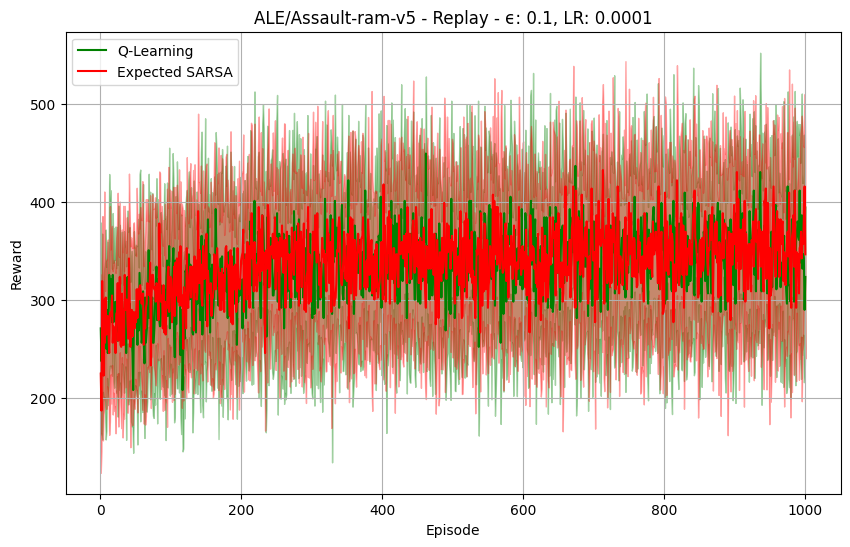

In [13]:
os.makedirs("plots", exist_ok=True)

env_name = "ALE/Assault-ram-v5"

# Enable interactive mode so that plt.show() doesn't block each time
plt.ion()

# List to keep track of figure objects 
figures = []

# Loop over every combination of replay, epsilon, and learning rate
for use_replay in replay_options:
    for epsilon in epsilon_list:
        for lr in lr_list:
            title = (f"{env_name} - " +
                     f"{'Replay' if use_replay else 'No Replay'} - " +
                     f"ϵ: {epsilon}, LR: {lr}")

            # Build the filename for this combination
            plot_filename = f"plots/{env_name}_{'replay' if use_replay else 'no_replay'}_eps{epsilon}_lr{lr}.png"

            # Variables to hold the rewards for each algorithm
            q_mean_rewards, q_std_rewards = None, None
            e_sarsa_mean_rewards, e_sarsa_std_rewards = None, None

            # Run each algorithm for this combination
            for algo in algorithms:
                training_title = (f"{env_name} - {algo.upper()} - " +
                                  f"{'Replay' if use_replay else 'No Replay'} - " +
                                  f"ϵ: {epsilon}, LR: {lr}")
                print("Running:", training_title)

                mean_rewards, std_rewards = run_multiple_trials(env_name, algo,
                                                                use_replay, epsilon,
                                                                lr, episodes)

                if algo == "q_learning":
                    q_mean_rewards, q_std_rewards = mean_rewards, std_rewards
                else:
                    e_sarsa_mean_rewards, e_sarsa_std_rewards = mean_rewards, std_rewards

            # Create the plot for the current combination
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.plot(episodes_range, q_mean_rewards, label="Q-Learning", color='green')
            ax.fill_between(episodes_range,
                            q_mean_rewards - q_std_rewards,
                            q_mean_rewards + q_std_rewards,
                            color='green', alpha=0.35)
            ax.plot(episodes_range, e_sarsa_mean_rewards, label="Expected SARSA", color='red')
            ax.fill_between(episodes_range,
                            e_sarsa_mean_rewards - e_sarsa_std_rewards,
                            e_sarsa_mean_rewards + e_sarsa_std_rewards,
                            color='red', alpha=0.35)

            ax.set_xlabel("Episode")
            ax.set_ylabel("Reward")
            ax.set_title(title)
            ax.legend()
            ax.grid(True)

            # Save the generated plot
            fig.savefig(plot_filename)
            print(f"Saved plot to {plot_filename}")
            figures.append(fig)

# Turn off interactive mode and display all the figures at once.
plt.ioff()
plt.show()